load packages and libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

Data cleaning. read the dataset. remove missing values. remove unused columns. remove invalid sales values "0". sample the data and create the train-test split.

In [8]:
df = pd.read_csv("Retail.csv")

df.dropna(inplace=True)

df["TotalSales"] = df["Quantity"] * df["UnitPrice"]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="%m/%d/%y %H:%M", errors="coerce")
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["DayOfWeek"] = df["InvoiceDate"].dt.dayofweek + 1  # Monday = 1
df["Hour"] = df["InvoiceDate"].dt.hour

df.drop(columns=["InvoiceNo", "StockCode", "Description", "InvoiceDate", "Country"], inplace=True)

df = df[df["TotalSales"] >= 0]

data_sample = df.sample(n=min(10000, len(df)), random_state=123)

train_data, test_data = train_test_split(data_sample, test_size=0.2, random_state=123)

Start exploratory data anlysis. create boxplot of total sales. scatterplot showing quantity vs total sales. correlation heatmap

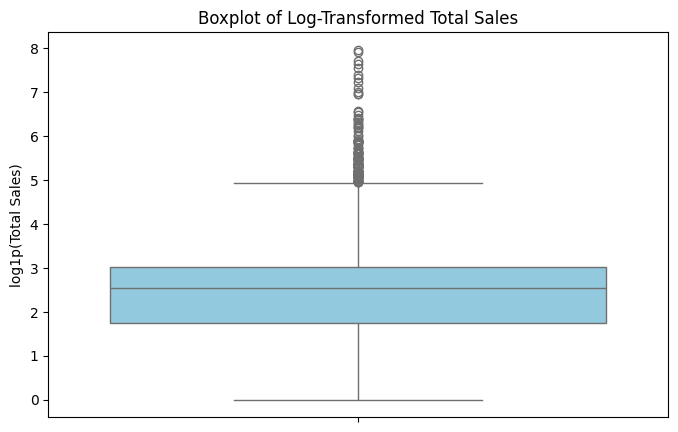

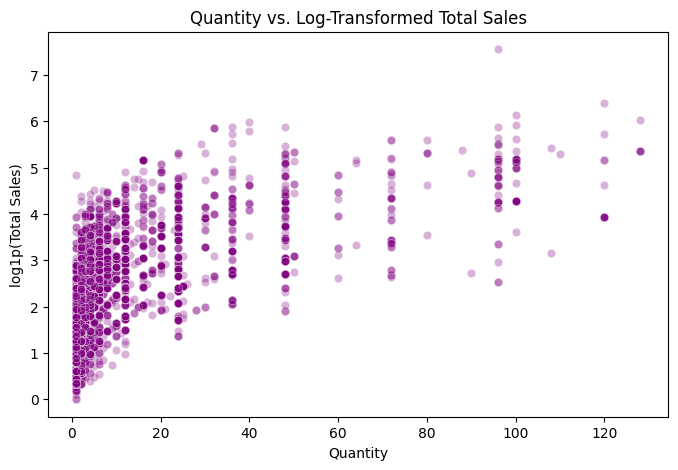

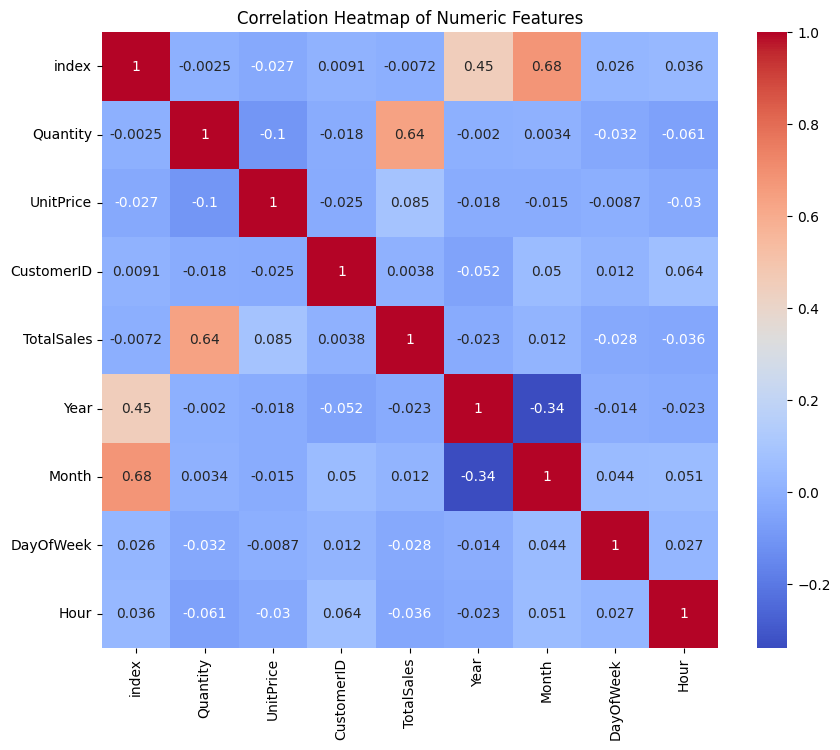

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=np.log1p(train_data["TotalSales"]), color="skyblue")
plt.title("Boxplot of Log-Transformed Total Sales")
plt.ylabel("log1p(Total Sales)")
plt.show()

filtered = train_data[(train_data["Quantity"] > 0) & (train_data["Quantity"] < train_data["Quantity"].quantile(0.99))]

plt.figure(figsize=(8, 5))
sns.scatterplot(x=filtered["Quantity"], y=np.log1p(filtered["TotalSales"]), alpha=0.3, color="purple")
plt.title("Quantity vs. Log-Transformed Total Sales")
plt.xlabel("Quantity")
plt.ylabel("log1p(Total Sales)")
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

Modeling. linear regression, decision tree, and a random forest

In [10]:
X = train_data.drop(columns=["TotalSales"])
y = train_data["TotalSales"]

lr_model = LinearRegression()
lr_model.fit(X, y)


dt_model = DecisionTreeRegressor(random_state=123)
dt_model.fit(X, y)


rf_model = RandomForestRegressor(n_estimators=25, random_state=123)
rf_model.fit(X, y)


median_sales = train_data["TotalSales"].median()
train_data["SalesCategory"] = np.where(train_data["TotalSales"] > median_sales, "High", "Low")
test_data["SalesCategory"] = np.where(test_data["TotalSales"] > median_sales, "High", "Low")

logit_train = train_data.drop(columns=["TotalSales"])
logit_test = test_data.drop(columns=["TotalSales"])

le = LabelEncoder()
logit_train["SalesCategory"] = le.fit_transform(logit_train["SalesCategory"])
logit_test["SalesCategory"] = le.transform(logit_test["SalesCategory"])

logit_X = logit_train.drop(columns=["SalesCategory"])
logit_y = logit_train["SalesCategory"]

logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(logit_X, logit_y)

LogisticRegression(max_iter=1000)

Model evaluation - 10 fold cross validation

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=123)


cv_scores_lr = cross_val_score(lr_model, X, y, cv=kfold, scoring="neg_root_mean_squared_error")
print("Linear Regression CV RMSE:", -np.mean(cv_scores_lr))


cv_scores_dt = cross_val_score(dt_model, X, y, cv=kfold, scoring="neg_root_mean_squared_error")
print("Decision Tree CV RMSE:", -np.mean(cv_scores_dt))


cv_scores_rf = cross_val_score(rf_model, X, y, cv=kfold, scoring="neg_root_mean_squared_error")
print("Random Forest CV RMSE:", -np.mean(cv_scores_rf))

Linear Regression CV RMSE: 59.962584051837425
Decision Tree CV RMSE: 37.47372707093628
Random Forest CV RMSE: 25.962396495117854


test set evaluation

In [13]:
X_test = test_data.drop(columns=["TotalSales", "SalesCategory"])
y_test = test_data["TotalSales"]

pred_lm = lr_model.predict(X_test)
pred_dt = dt_model.predict(X_test)
pred_rf = rf_model.predict(X_test)

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}: RMSE={rmse:.2f}, R²={r2:.4f}")

print("\nTest-Set Performance:")
evaluate_model(y_test, pred_lm, "Linear Model")
evaluate_model(y_test, pred_dt, "Decision Tree")
evaluate_model(y_test, pred_rf, "Random Forest")


Test-Set Performance:
Linear Model: RMSE=35.38, R²=0.0793
Decision Tree: RMSE=14.84, R²=0.8381
Random Forest: RMSE=11.13, R²=0.9089


logistic regression evaluation


Confusion Matrix:
[[732 263]
 [136 869]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       995
           1       0.77      0.86      0.81      1005

    accuracy                           0.80      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.80      0.80      2000



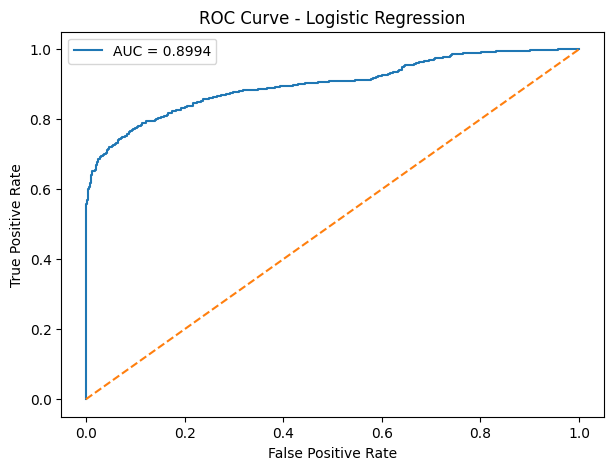

In [14]:
logit_test_X = logit_test.drop(columns=["SalesCategory"])
logit_test_y = logit_test["SalesCategory"]

pred_probs = logit_model.predict_proba(logit_test_X)[:, 1]
pred_classes = (pred_probs > 0.5).astype(int)

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(logit_test_y, pred_classes))
print("\nClassification Report:")
print(classification_report(logit_test_y, pred_classes))

# ROC & AUC
fpr, tpr, _ = roc_curve(logit_test_y, pred_probs)
auc_score = roc_auc_score(logit_test_y, pred_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

Variable Importance

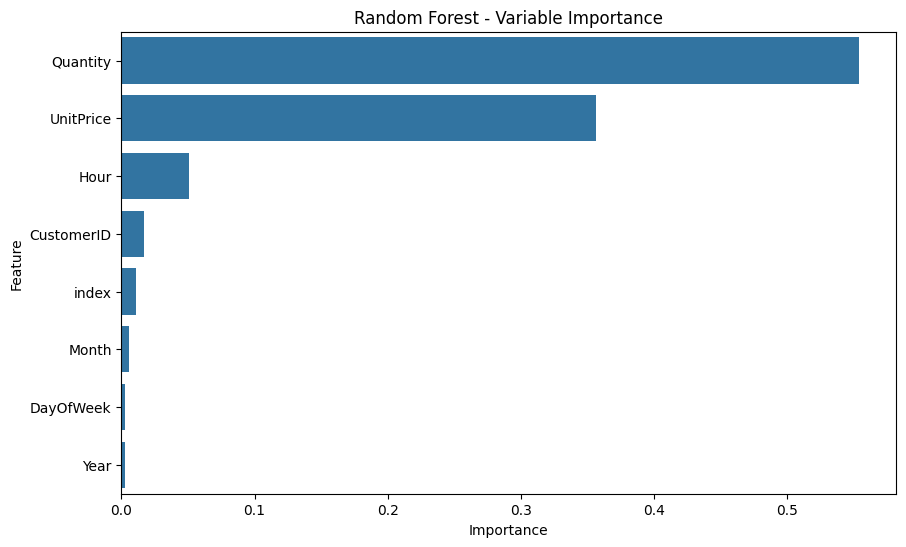

In [15]:
importances = rf_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Random Forest - Variable Importance")
plt.show()